In [1]:
!pip install PyMySQL ipython-sql pandas matplotlib scikit-learn sqlalchemy

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

# Database connection parameters
db_name = "tawos_db"
db_host = "localhost"
db_username = "root"
db_password = "pranavan"

try:
    # Create a connection using SQLAlchemy
    connection_string = f"mysql+pymysql://{db_username}:{db_password}@{db_host}/{db_name}"
    engine = create_engine(connection_string)
    print("Connection successful")
except Exception as e:
    print("Error:", e)

Connection successful


In [3]:
# Fetch the data using pandas' read_sql method
issue_query = """
SELECT 
    Type, 
    Priority, 
    Timespent, 
    Story_Point, 
    Resolution_Time_Minutes
FROM Issue;
"""
issue_df = pd.read_sql(issue_query, engine)

# Query Sprint table
sprint_query = """
SELECT 
    State, 
    Start_Date, 
    End_Date
FROM Sprint;
"""
sprint_df = pd.read_sql(sprint_query, engine)

# Query Change_Log table
change_log_query = """
SELECT 
    Change_Type, 
    Creation_Date
FROM Change_Log;
"""
change_log_df = pd.read_sql(change_log_query, engine)

# Display data samples
print("Issue Table Sample:\n", issue_df.head())
print("Sprint Table Sample:\n", sprint_df.head())
print("Change Log Table Sample:\n", change_log_df.head())

# Close the engine connection
engine.dispose()

Issue Table Sample:
     Type Priority  Timespent  Story_Point  Resolution_Time_Minutes
0    Bug    Major        NaN          1.0                      0.0
1    Bug  Trivial        NaN          1.0                      0.0
2    Bug    Major        NaN         10.0                      0.0
3  Story    Minor        NaN          8.0                      0.0
4    Bug    Major        NaN          5.0                      0.0
Sprint Table Sample:
     State           Start_Date             End_Date
0  CLOSED  2016-02-16 00:38:45  2016-02-26 08:34:00
1  CLOSED  2016-02-01 17:20:14  2016-02-13 01:16:00
2  CLOSED  2015-12-17 18:20:12  2015-12-26 02:16:00
3  CLOSED  2015-11-30 16:32:01  2015-12-11 17:28:00
4  CLOSED  2015-11-16 16:10:26  2015-11-27 17:06:00
Change Log Table Sample:
    Change_Type       Creation_Date
0        OTHER 2017-01-23 10:21:48
1        OTHER 2017-03-21 16:54:56
2       STATUS 2017-03-21 16:55:23
3       STATUS 2017-03-21 16:55:23
4  DESCRIPTION 2017-03-22 18:27:01


In [4]:
from sklearn.preprocessing import StandardScaler

# Combine data (Assume common IDs are used; adjust as necessary)
combined_df = pd.concat([issue_df, sprint_df, change_log_df], axis=1)

# Separate numeric and categorical columns
numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = combined_df.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the mean
combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].mean())

# Fill missing values in categorical columns with the mode
for col in categorical_columns:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

# Select numeric columns for clustering
numeric_data = combined_df.select_dtypes(include=['float64', 'int64'])

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Display the normalized data
print("Normalized Data Sample:\n", scaled_data[:5])

Normalized Data Sample:
 [[-1.23357383e-13 -4.69870645e-02 -2.06552779e+00]
 [-1.23357383e-13 -4.69870645e-02 -2.06552779e+00]
 [-1.23357383e-13 -4.59620706e-02 -2.06552779e+00]
 [-1.23357383e-13 -4.61898470e-02 -2.06552779e+00]
 [-1.23357383e-13 -4.65315116e-02 -2.06552779e+00]]


In [5]:
from sklearn.cluster import KMeans

# Define the number of clusters
k = 3

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(scaled_data)

# Add cluster labels to the original DataFrame
combined_df['Cluster'] = kmeans.labels_

# Display the clustered data (first 5 rows as an example)
print("Clustered Data Sample:\n", combined_df.head())

# Optional: If you want to see the cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

Clustered Data Sample:
     Type Priority   Timespent  Story_Point  Resolution_Time_Minutes   State  \
0    Bug    Major  323.090501          1.0                      0.0  CLOSED   
1    Bug  Trivial  323.090501          1.0                      0.0  CLOSED   
2    Bug    Major  323.090501         10.0                      0.0  CLOSED   
3  Story    Minor  323.090501          8.0                      0.0  CLOSED   
4    Bug    Major  323.090501          5.0                      0.0  CLOSED   

            Start_Date             End_Date  Change_Type       Creation_Date  \
0  2016-02-16 00:38:45  2016-02-26 08:34:00        OTHER 2017-01-23 10:21:48   
1  2016-02-01 17:20:14  2016-02-13 01:16:00        OTHER 2017-03-21 16:54:56   
2  2015-12-17 18:20:12  2015-12-26 02:16:00       STATUS 2017-03-21 16:55:23   
3  2015-11-30 16:32:01  2015-12-11 17:28:00       STATUS 2017-03-21 16:55:23   
4  2015-11-16 16:10:26  2015-11-27 17:06:00  DESCRIPTION 2017-03-22 18:27:01   

   Cluster  
0      

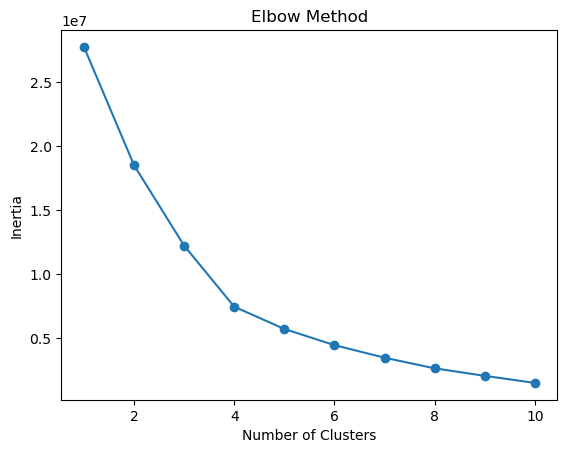

In [6]:
import matplotlib.pyplot as plt

# Use the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [7]:
# Save the clustered data to a CSV file
combined_df.to_csv('clustered_results.csv', index=False)
print("Clustered results saved to 'clustered_results.csv'")

Clustered results saved to 'clustered_results.csv'
